# Set Covering

In [944]:
from random import random, seed
from itertools import accumulate
import numpy as np
from tqdm.auto import tqdm
from icecream import ic
from matplotlib import pyplot as plt

In [945]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [946]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

*Helper function*

In [947]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

# First dumb solutions

In [948]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(277.5988592454046))

In [949]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.False_, np.float64(142.4869373005088))

# First Hill Climbing solution (RMHC)

In [950]:
def tweak1(solution):
    """Returns a new solution by flipping a random set"""
    new_solution = solution.copy()
    index= rng.integers(NUM_SETS)
    new_solution[index] = ~new_solution[index]
    return new_solution
    

In [951]:
def fitness(solution):
    """Returns the fitness of a solution"""
    return (valid(solution), -cost(solution)) 

In [952]:
def starting_point():
    """Returns a valid starting point"""
    solution = rng.random(NUM_SETS) < 1
    return solution

ic| fitness(solution): (np.True_, np.float64(-277.5988592454046))
ic| history.index(fitness(solution)): 0


(np.True_, np.float64(277.5988592454046))

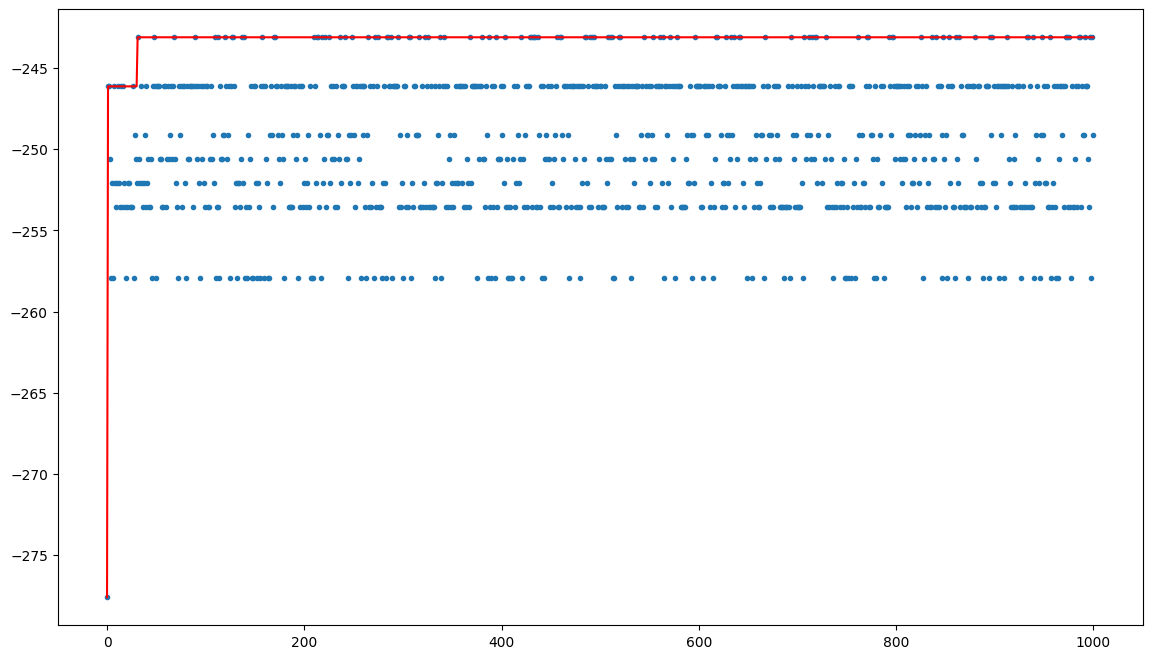

In [953]:
MAX_STEPS = 1000

def hill_climb(tweak):
    solution = starting_point()
    history = [fitness(solution)]
    for _ in range(MAX_STEPS):
        new_solution = tweak(solution)
        history.append(fitness(new_solution))
        if fitness(new_solution) > fitness(solution):
            solution = new_solution
    
    ic(fitness(solution))
    ic(history.index(fitness(solution)))    
    c_values = [c for v, c in history]

    plt.figure(figsize=(14, 8))

    # Grafico dell'accumulazione del massimo di 'c'
    plt.plot(
        range(len(c_values)),
        list(accumulate(c_values, max)),
        color="red",
    )

    # Scatter plot per visualizzare i singoli valori di 'c'
    _ = plt.scatter(range(len(c_values)), c_values, marker=".")
    return solution
solution = hill_climb(tweak1)
valid(solution), cost(solution)

# Second Hill Climbing solution RMHC (new tweak func)

In [954]:
def tweak2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:
        index= rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    return new_solution

ic| fitness(solution): (np.True_, np.float64(-277.5988592454046))
ic| history.index(fitness(solution)): 0


(np.True_, np.float64(277.5988592454046))

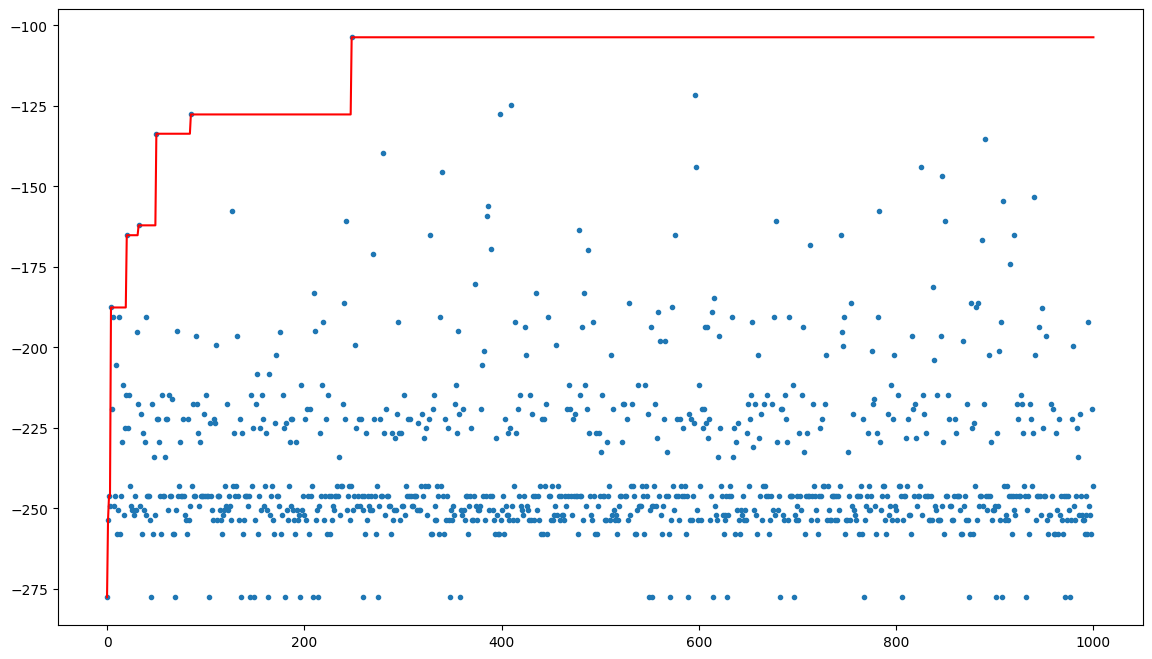

In [955]:

solution = hill_climb(tweak2)
valid(solution), cost(solution)

# Steepest step and restart

  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/66 [00:00<?, ?it/s]

step 2:   0%|          | 0/66 [00:00<?, ?it/s]

step 3:   0%|          | 0/66 [00:00<?, ?it/s]

(np.True_, np.float64(277.5988592454046))

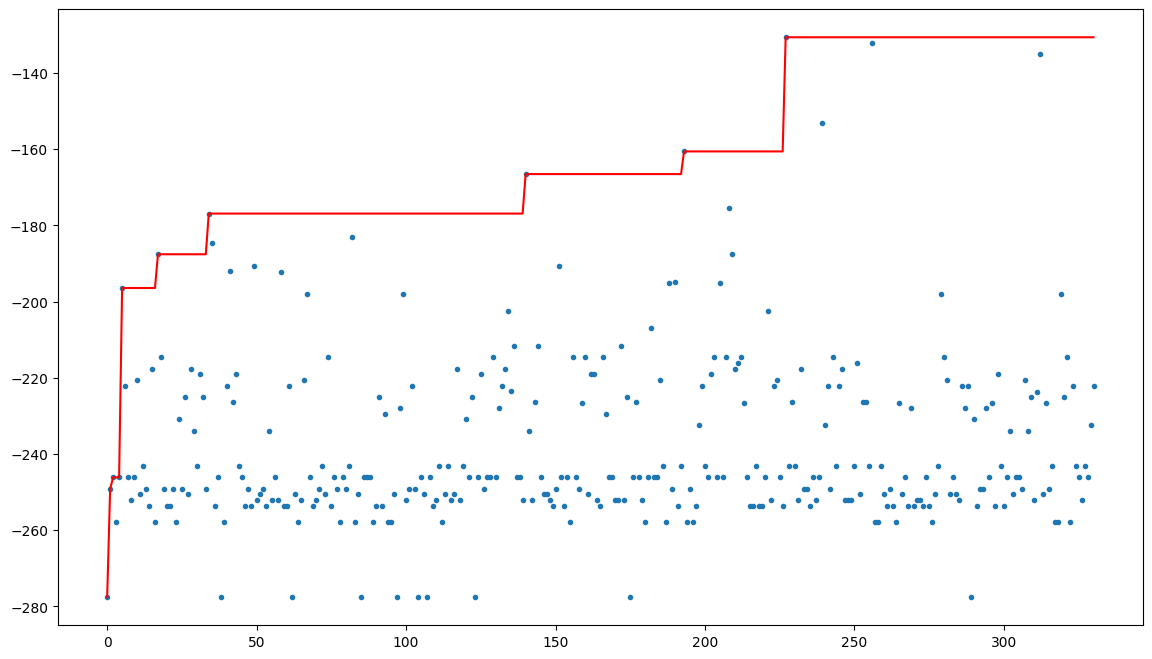

In [956]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = MAX_STEPS // STEEPEST_STEP_CANDIDATES
for i in tqdm(range(NUM_RESTARTS), position=0):
    solution = starting_point()
    history = [fitness(solution)]
    for _ in tqdm (range(TRUE_MAX_STEPS//NUM_RESTARTS), position=1, desc=f'step {i+1}'):
        candidates = [tweak2(solution) for _ in range(STEEPEST_STEP_CANDIDATES)]
        candidates_fitness = list()

        for candidate in candidates:
            candidates_fitness.append(fitness(candidate))
            history.append(fitness(candidate))
        idx = candidates_fitness.index(max(candidates_fitness))   
        new_solution = candidates[idx]
        new_fitness = candidates_fitness[idx]
        if new_fitness > fitness(solution):
            solution = new_solution
plt.figure(figsize=(14, 8))
c_values = [c for v, c in history]
plt.plot(
    range(len(c_values)),
    list(accumulate(c_values, max)),
    color="red",
)
_ = plt.scatter(range(len(c_values)), c_values, marker=".")
valid(solution), cost(solution)
